In [1]:
import pandas as pd
import numpy as np
from invertiblewavelets import Transform
import matplotlib.pyplot as plt
from invertiblewavelets import *
from scipy import signal
from scipy.ndimage import label, binary_closing, gaussian_filter1d, binary_dilation

#### Load Example Data from Swarm A Spacecraft Magnetoemter

5.6554178213641615


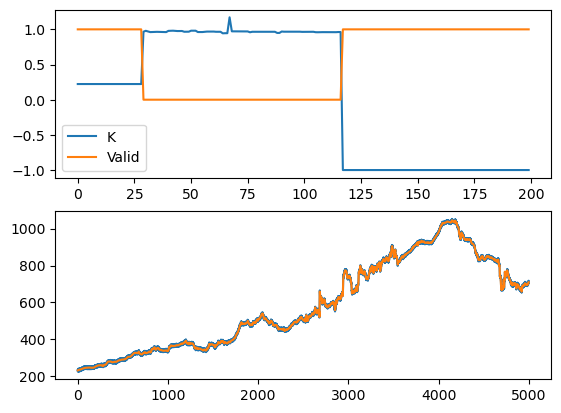

In [7]:
"Load Data"
data = np.load("data.npy")

# Adding some noise
sample_rate = 50.0                          # 50 Hz sampling rate
num_samples = data.shape[-1]                # 5000 samples
t = np.arange(num_samples) / sample_rate    # time array
B1 = data - 10 *np.sin(2 * np.pi * 20 * t) + 50 * np.sin(2 * np.pi * .5 * t)
B2 = data + 10 *np.sin(2 * np.pi * 20 * t) + 10*np.sin(2 * np.pi * .5 * t)
B = np.vstack((B1,B2))

"Wavelet Transform"
transform = Transform(
    data=data,
    fs = sample_rate,
    wavelet=Cauchy(1000), # Wavelet to use
    #pad_method=None, # Padding method for the convolution calls np.pad. Set to None if no padding
    b = 8
)

"Perform forward wavelet transform"
w1 = transform.forward(B[0])
w2 = transform.forward(B[1])


dw = w2-w1
wc1 = np.sum(dw*w1.conj(), axis=1) / np.sum(np.abs(w1)**2, axis=1)
wc2 = np.sum(dw*w2.conj(), axis=1) / np.sum(np.abs(w1)**2, axis=1)

# Detect interference segments (adjust threshold as needed)
#valid_mask =  (gaussian_filter1d(np.abs(wc1)+np.abs(wc2), sigma = 5) > 1e-1) 

# Use morphological closing to merge nearby regions and remove small gaps
#valid_mask = binary_closing(valid_mask, structure=np.ones(5))

# Label contiguous segments
#labeled_mask, num_segments = label(valid_mask)

# Calculate the K factor
k_hat = np.mean(dw*w2.conj() / (dw*w1.conj()) , axis=1).real

# Check the condition of each sub-sensing matrix
mixing_matrices = np.empty((len(k_hat), 2, 2))
mixing_matrices[:, 0, :] = [1, 1]          # First row is always [1, 1]
mixing_matrices[:, 1, 0] = 1               # Second row first column is 1
mixing_matrices[:, 1, 1] = k_hat           # Second row second column is k_hat

# Compute singular values for all matrices at once
_, s, _ = np.linalg.svd(mixing_matrices)
condition_numbers = s[:, 0] / s[:, 1]

# Create mask where condition is bad
valid_mask = condition_numbers < 10
valid_mask = binary_closing(valid_mask, structure=np.ones(5))
valid_mask = binary_dilation(valid_mask, structure=np.ones(50))

# Label contiguous segments
labeled_mask, num_segments = label(valid_mask)

# Process each segment

for seg_id in range(1, num_segments + 1):
    # Extract frequency bins in the current segment
    segment_mask = labeled_mask == seg_id
    k_segment = k_hat[segment_mask]

    if(np.mean(k_segment) < 1):
        k_hat[segment_mask] = np.min(k_segment)
    else:
        print("Max")
        k_hat[segment_mask] = np.max(k_segment)



# Apply K to compute clean signal
k = k_hat[:, np.newaxis]
#w_clean1 = (k * w1 - w2) / (k - 1)
#w_clean2 = ((k-1) * w1 - w2) / (k - 1)
#w_clean = (w_clean1 + w_clean2) / 2
# Fallback to sensor averaging in non-interference regions
#weights_1 = 1/(np.abs(wc1) +1)[:, np.newaxis]
#weights_2 = 1/(np.abs(wc2) +1)[:, np.newaxis]
#w_clean[~valid_mask] = (weights_1[~valid_mask]*w1[~valid_mask]+ weights_2[~valid_mask]*w2[~valid_mask]) / (weights_1[~valid_mask] + weights_2[~valid_mask])
weights = 1 / (condition_numbers + 1)
weights = weights[:, np.newaxis]


transform.pad_width

epsilon = 1e-6
denominator = k - 1
#denominator[np.abs(denominator) < epsilon] = epsilon * np.sign(denominator[np.abs(denominator) < epsilon])
w_clean = np.copy(w1)
w_clean[:,transform.pad_width:-transform.pad_width] = weights * ((k * w1[:,transform.pad_width:-transform.pad_width] - w2[:,transform.pad_width:-transform.pad_width]) / (denominator)) + (1 - weights) * ((w1[:,transform.pad_width:-transform.pad_width] + w2[:,transform.pad_width:-transform.pad_width]) / 2)

# Find nan values and replace them with the average of the two sensors
nan_mask = np.isnan(w_clean[:, 0])
weights_1 = 1/(np.abs(wc1) +1)[:, np.newaxis]
weights_2 = 1/(np.abs(wc2) +1)[:, np.newaxis]
w_clean[nan_mask] = (weights_1[nan_mask]*w1[nan_mask]+ weights_2[nan_mask]*w2[nan_mask]) / (weights_1[nan_mask] + weights_2[nan_mask])

w_clean = np.copy(w1)/2 + np.copy(w2) / 2
w_clean[valid_mask] = (k[valid_mask] * w1[valid_mask] - w2[valid_mask]) / (k[valid_mask] - 1)

result = transform.inverse(np.copy(w_clean))
print(np.sqrt(((data[100:-100]-result[100:-100])**2).mean(axis=0)))


fig, ax = plt.subplots(2,1)
ax[0].plot( k_hat, label='K')
ax[0].plot(np.array(valid_mask, dtype=int), label='Valid')
ax[0].legend()
ax[1].plot(result)
ax[1].plot(data)


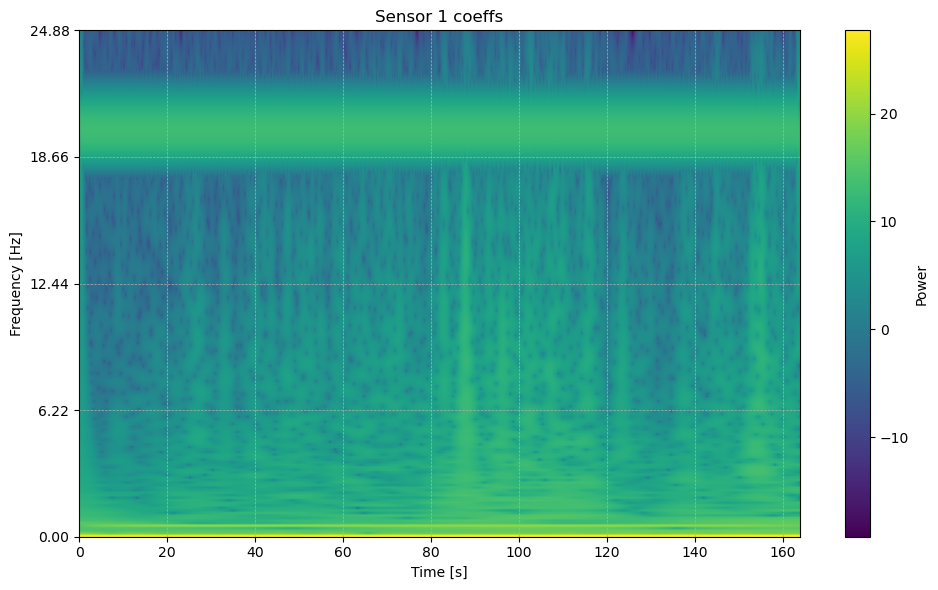

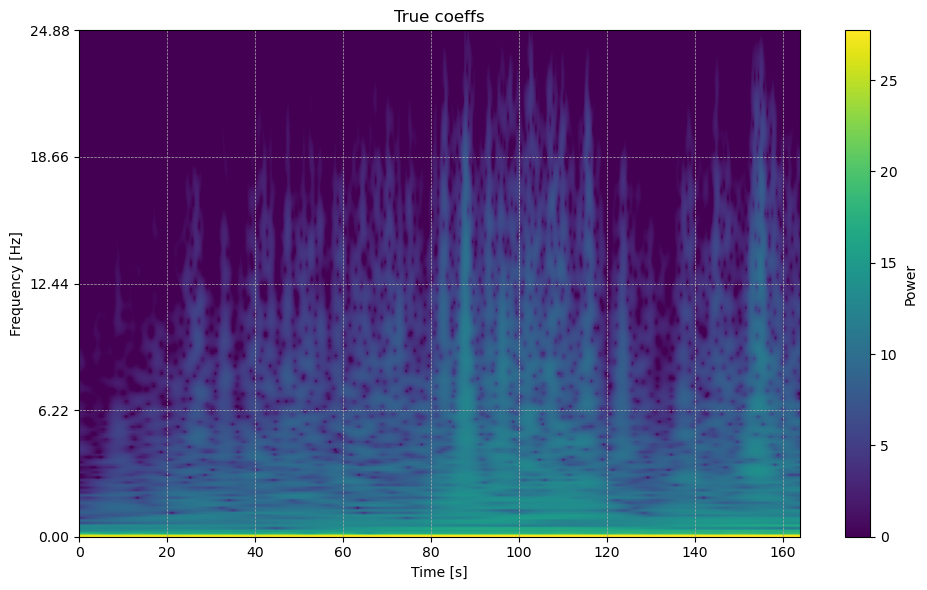

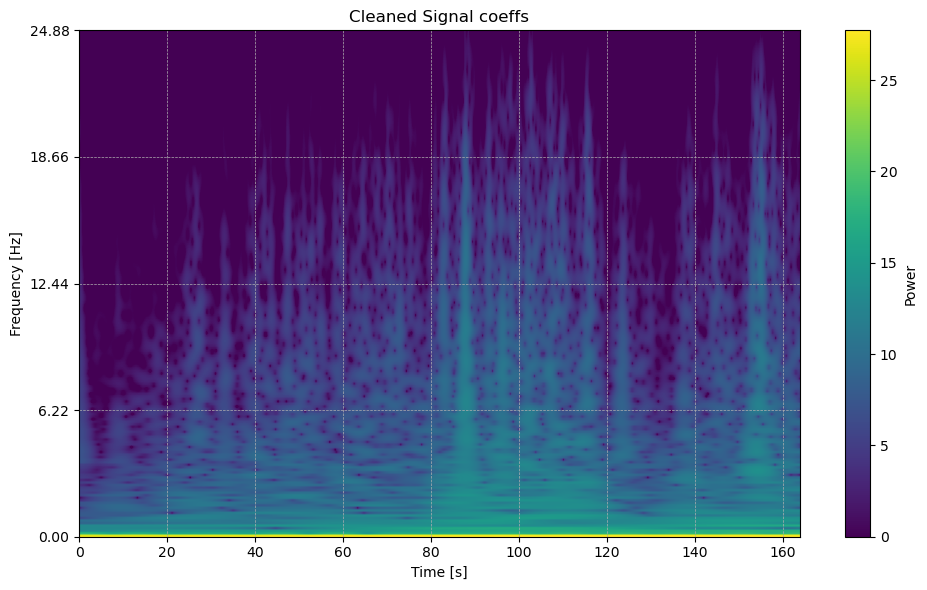

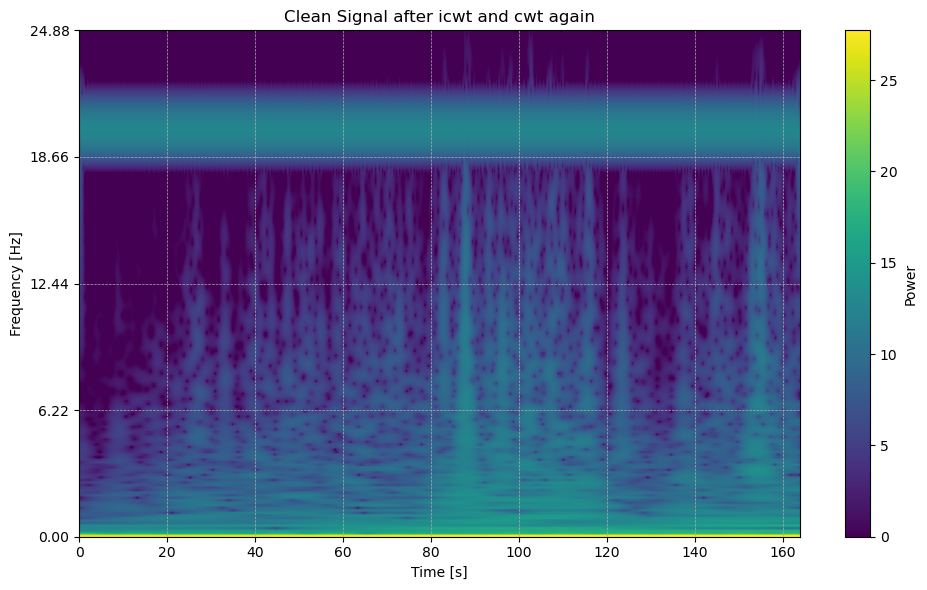

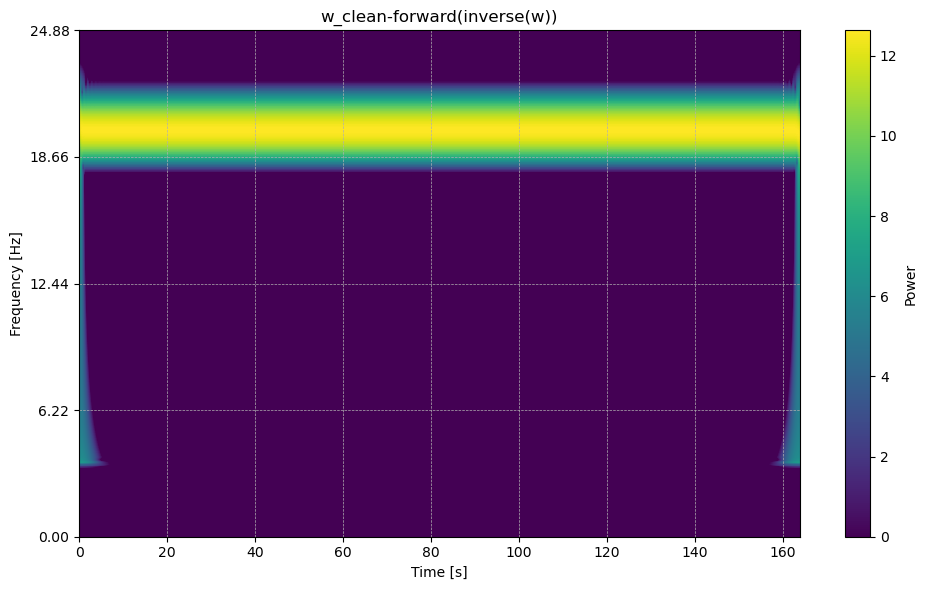

In [8]:
transform.power_scalogram(w1,  title = 'Sensor 1 coeffs')
transform.power_scalogram(transform.forward(data), vmin=0, title = 'True coeffs')
transform.power_scalogram(w_clean, vmin=0, title = 'Cleaned Signal coeffs')
result = transform.inverse(w_clean)
w = transform.forward(result)
transform.power_scalogram(w, vmin=0, title = 'Clean Signal after icwt and cwt again')
transform.power_scalogram(w_clean-w, vmin=0, title = 'w_clean-forward(inverse(w))')

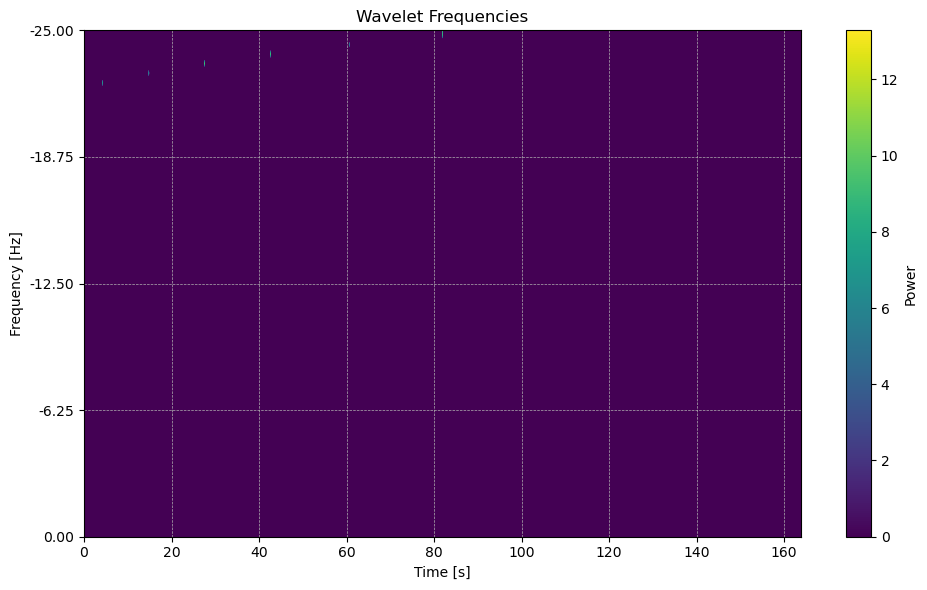

In [5]:
transform.power_scalogram(transform.Wfreq, vmin=0, title = 'Wavelet Frequencies')

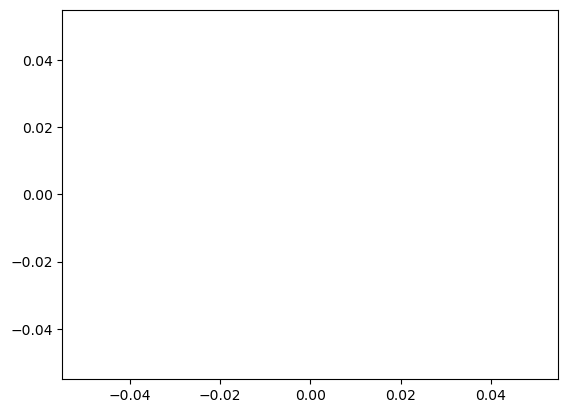

In [7]:
c2Dfreq = np.fft.fft(w_clean, axis=1)  

# Weighted sum in freq: XhatFreq = [1/Sfreq] * sum_j conj(Wfreq[j,:]) * c2Dfreq[j,:]
numerator =  np.sum(np.conj(transform.Wfreq) * c2Dfreq, axis=0)
XhatFreq = numerator / transform.Sfreq
xhat_time = np.fft.ifft(XhatFreq).real

plt.plot(xhat_time)


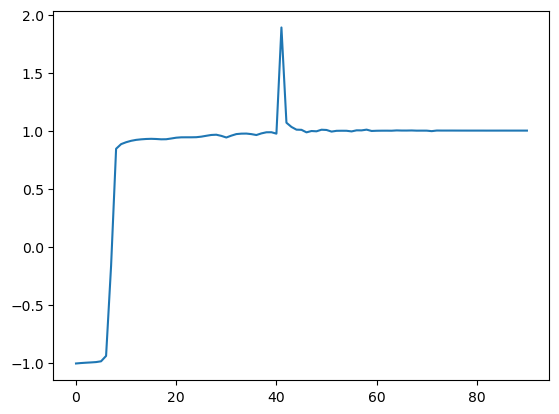

In [8]:

from wavelets import WaveletAnalysis
w1 = WaveletAnalysis(B[0], dt=1/sample_rate, frequency=True, dj = 1/8, unbias=False, mask_coi = True)
w2 = WaveletAnalysis(B[1], dt=1/sample_rate, frequency=True, dj = 1/8, unbias=False, mask_coi = True)

"Transform signals into wavelet domain"
wn1 = w1.wavelet_transform.real
wn2 = w2.wavelet_transform.real

"Sheinker and Moldwin's Algorithm"
dw = wn2-wn1
wc1 = np.sum(dw*wn1, axis=1)
wc2 = np.sum(dw*wn2, axis=1)
k_hat_real = wc2/wc1
plt.plot(k_hat_real)

#### WAICUP


(199.53833733562513+0j)


c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


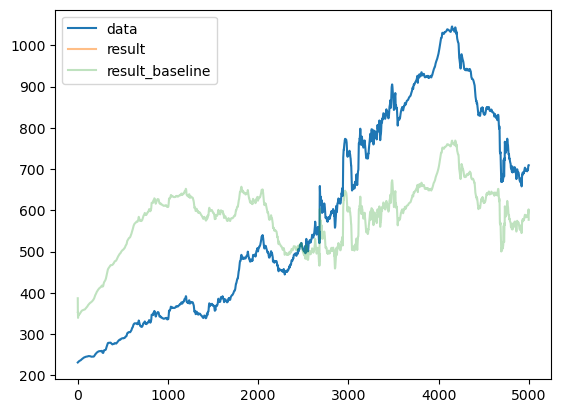

In [9]:
from magprime.algorithms import WAICUP
%matplotlib inline
WAICUP.fs = sample_rate
WAICUP.detrend = False
result_baseline = WAICUP.clean(B, triaxial=False)
print(np.sqrt(((data-result_baseline)**2).mean(axis=0)))
plt.plot(data, label='data')
plt.plot(result, label='result', alpha=0.5)
plt.plot(result_baseline, label='result_baseline', alpha=0.3)
plt.legend()

In [10]:
1/6.10351562e-03



163.84000013421775